In [ ]:
!pip install transformers torch pandas scikit-learn

##Import libraries

In [ ]:
import pandas as pd
import torch
from transformers import pipeline, BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

##Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Load dataset from Drive

In [ ]:
file_path = '/content/drive/MyDrive/DS data/russian vs ukraine war.csv'
df = pd.read_csv(file_path)
df.head()
print(df.columns)
df.isnull()


Index(['Comments'], dtype='object')


,Comments
0,False
1,False
2,False
3,False
4,False
...,...
9987,False
9988,False
9989,False
9990,False


##Generate lable automatically

In [ ]:
from transformers import pipeline
from tqdm import tqdm

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

possible_labels = ["russian pro", "ukraine pro", "neutral"]

texts = df["Comments"].astype(str).tolist()

predicted_labels = []

batch_size = 16
for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i + batch_size]
    results = classifier(batch, possible_labels)
    for r in results:
        predicted_labels.append(r["labels"][0])

df["label"] = predicted_labels

df.head()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
100%|██████████| 625/625 [10:46<00:00,  1.04s/it]


,Comments,label
0,"Big Satan is the US, Little Satan is Israel!",ukraine pro
1,Reminds one of a meeting between Adolf and Ben...,ukraine pro
2,Actually Erdogan is a Vulture waiting to gobbl...,russian pro
3,To whom it may concern Proud of the state of t...,ukraine pro
4,A lot of crowing but none of you have done any...,neutral


##Encode label numerically

In [ ]:
label_map = {'russian pro': 0, 'ukraine pro': 1, 'neutral': 2}
df['label'] = df['label'].map(label_map)

##Split dataset

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Comments'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)

##Tokenize and create dataset

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

##Fine-tune BERT

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.6074
Epoch 2, Loss: 0.4040
Epoch 3, Loss: 0.2126
Epoch 4, Loss: 0.1092
Epoch 5, Loss: 0.0579


##Classification, confusion matrix, ROC Auc

=== Classification Report ===
              precision    recall  f1-score   support

 russian pro       0.88      0.91      0.89       685
 ukraine pro       0.86      0.89      0.87      1053
     neutral       0.80      0.58      0.67       261

    accuracy                           0.86      1999
   macro avg       0.84      0.80      0.81      1999
weighted avg       0.86      0.86      0.85      1999



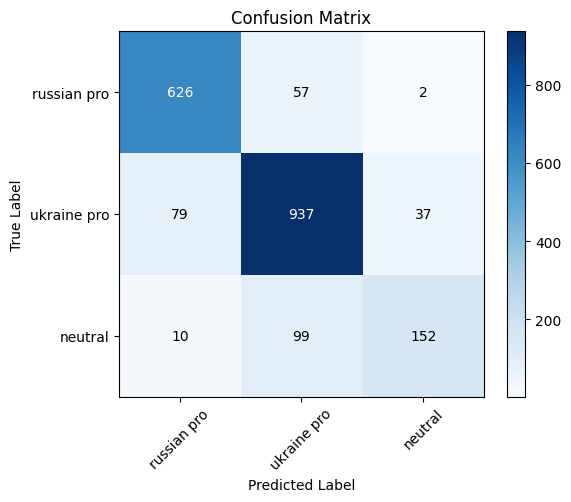

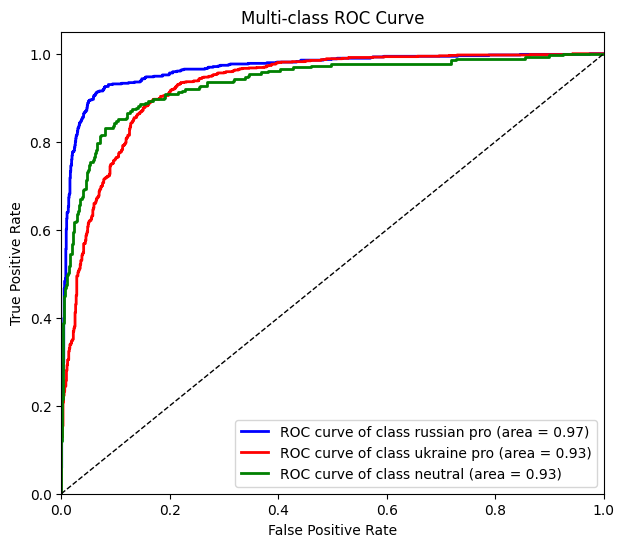

Average AUC Score: 0.9425229281144762


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from sklearn.preprocessing import label_binarize
import torch

# Put model in evaluation mode
model.eval()

# Store predictions and true labels
preds, true_labels, probs = [], [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)

        preds.extend(torch.argmax(probabilities, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        probs.extend(probabilities.cpu().numpy())

# Classification Report
print("=== Classification Report ===")
print(classification_report(true_labels, preds, target_names=['russian pro', 'ukraine pro', 'neutral']))

# Confusion Matrix
cm = confusion_matrix(true_labels, preds)
classes = ['russian pro', 'ukraine pro', 'neutral']

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


# ROC Curve (for multi-class)
y_true_bin = label_binarize(true_labels, classes=[0, 1, 2])
probs = np.array(probs)
n_classes = y_true_bin.shape[1]

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curves
plt.figure(figsize=(7, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

print("Average AUC Score:", roc_auc_score(y_true_bin, probs, average='macro'))

##Predict

In [ ]:
def predict_sentiment(text):
    model.eval()
    encoding = tokenizer(
        text,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)
    with torch.no_grad():
        outputs = model(**encoding)
    pred = torch.argmax(outputs.logits, dim=-1).cpu().item()
    for key, val in label_map.items():
        if val == pred:
            return key

# Example predictions
print(predict_sentiment("Ukraine deserves support."))
print(predict_sentiment("300+ Palestinians in Gaza, zero coverage."))
print(predict_sentiment("Dear Russia i'm your big fan so plz dont kill innocent people."))

ukraine pro
neutral
russian pro


##RoBERTa Fine-Tuning

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
model_roberta = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
model_roberta.to(device)

optimizer = AdamW(model_roberta.parameters(), lr=2e-5)

for epoch in range(15):
    model_roberta.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model_roberta(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.7811
Epoch 2, Loss: 0.6310
Epoch 3, Loss: 0.5634
Epoch 4, Loss: 0.4942
Epoch 5, Loss: 0.4237
Epoch 6, Loss: 0.3485
Epoch 7, Loss: 0.2800
Epoch 8, Loss: 0.2367
Epoch 9, Loss: 0.1903
Epoch 10, Loss: 0.1611
Epoch 11, Loss: 0.1312
Epoch 12, Loss: 0.1238
Epoch 13, Loss: 0.1121
Epoch 14, Loss: 0.1069
Epoch 15, Loss: 0.0880


##classification, confusion, roc auc

=== Accuracy: 0.8044 ===

=== Classification Report ===
              precision    recall  f1-score   support

 russian pro       0.87      0.85      0.86       685
 ukraine pro       0.82      0.83      0.82      1053
     neutral       0.58      0.60      0.59       261

    accuracy                           0.80      1999
   macro avg       0.76      0.76      0.76      1999
weighted avg       0.81      0.80      0.81      1999



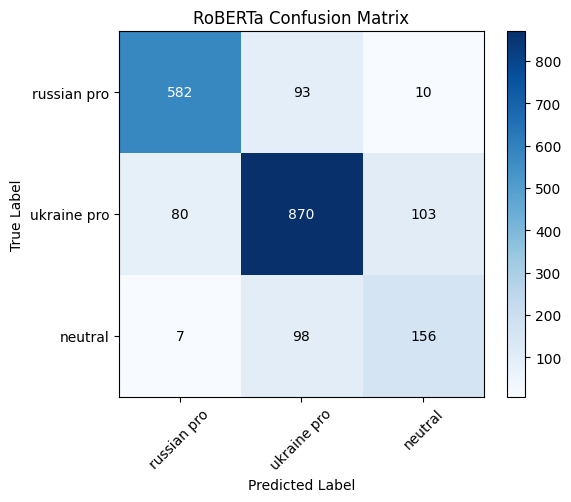

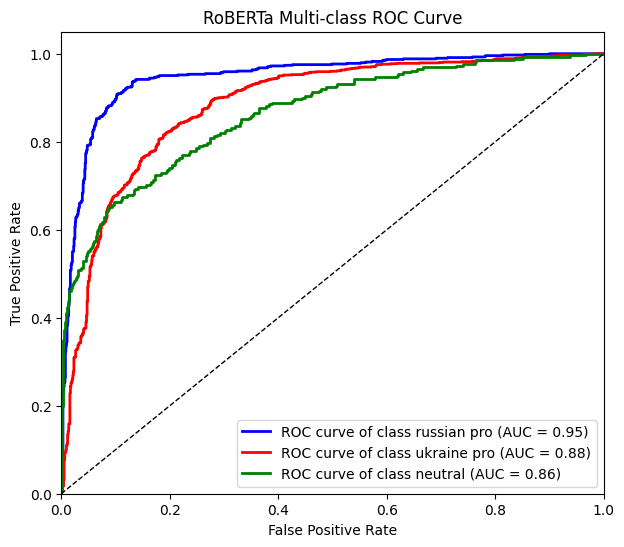

Average AUC Score: 0.8986027525882535


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
import torch

# --- Evaluation ---
model_roberta.eval()

preds, true_labels, probs = [], [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model_roberta(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)

        preds.extend(torch.argmax(probabilities, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        probs.extend(probabilities.cpu().numpy())

# --- Accuracy ---
accuracy = accuracy_score(true_labels, preds)
print(f"=== Accuracy: {accuracy:.4f} ===\n")

# --- Classification Report ---
class_names = ['russian pro', 'ukraine pro', 'neutral']
print("=== Classification Report ===")
print(classification_report(true_labels, preds, target_names=class_names))

# --- Confusion Matrix ---
cm = confusion_matrix(true_labels, preds)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("RoBERTa Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# --- ROC Curve (multi-class) ---
y_true_bin = label_binarize(true_labels, classes=[0, 1, 2])
probs = np.array(probs)
n_classes = y_true_bin.shape[1]

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RoBERTa Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

print("Average AUC Score:", roc_auc_score(y_true_bin, probs, average='macro'))


##predict

In [ ]:
def predict_sentiment_roberta(text):
    model_roberta.eval()
    encoding = tokenizer_roberta(
        text,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)
    with torch.no_grad():
        outputs = model_roberta(**encoding)
    pred = torch.argmax(outputs.logits, dim=-1).cpu().item()
    for key, val in label_map.items():
        if val == pred:
            return key

#Example Predictions
print(predict_sentiment_roberta("Ukraine deserves support."))
print(predict_sentiment_roberta("300+ Palestinians in Gaza, zero coverage."))
print(predict_sentiment_roberta("Dear Russia i'm your big fan so plz dont kill innocent people."))

neutral
ukraine pro
ukraine pro


##SVM model

=== SVM Accuracy: 0.7834 ===

=== Classification Report ===
              precision    recall  f1-score   support

 russian pro       0.83      0.78      0.80       685
 ukraine pro       0.76      0.89      0.82      1053
     neutral       0.80      0.35      0.49       261

    accuracy                           0.78      1999
   macro avg       0.79      0.67      0.70      1999
weighted avg       0.79      0.78      0.77      1999



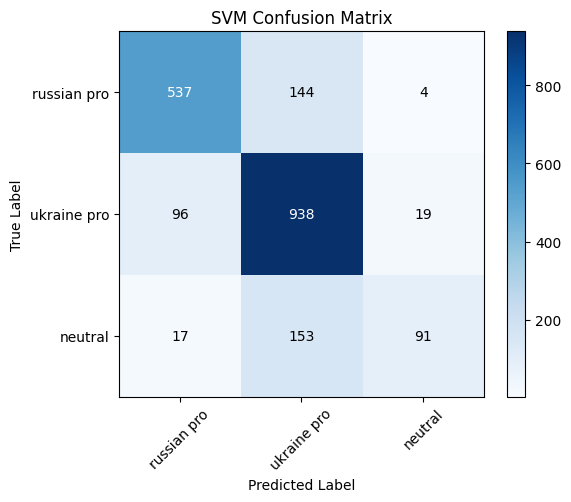

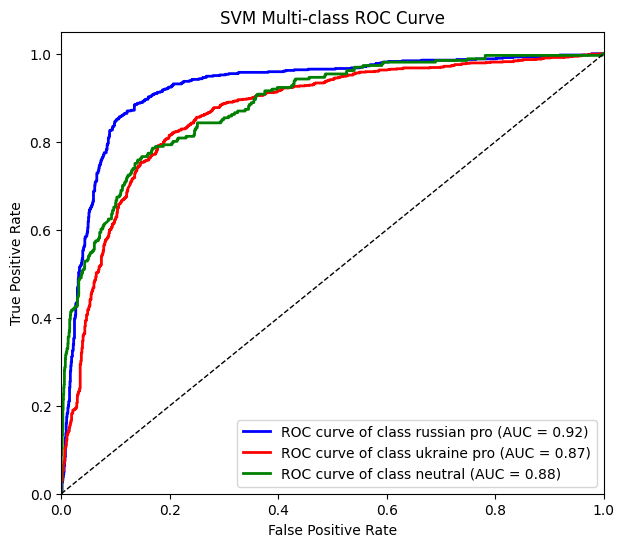

Average AUC Score: 0.891454877626008


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

# Train SVM Model
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, train_labels)

# Predictions
svm_preds = svm_model.predict(X_test)
svm_probs = svm_model.predict_proba(X_test)

#Accuracy
accuracy = accuracy_score(test_labels, svm_preds)
print(f"=== SVM Accuracy: {accuracy:.4f} ===\n")

#Classification Report
class_names = ['russian pro', 'ukraine pro', 'neutral']
print("=== Classification Report ===")
print(classification_report(test_labels, svm_preds, target_names=class_names))

#Confusion Matrix
cm = confusion_matrix(test_labels, svm_preds)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("SVM Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# ROC Curve (multi-class)
y_true_bin = label_binarize(test_labels, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], svm_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

print("Average AUC Score:", roc_auc_score(y_true_bin, svm_probs, average='macro'))

##predict

In [ ]:
def predict_sentiment_svm(text):
    text_vec = vectorizer.transform([text])
    pred = svm_model.predict(text_vec)[0]
    for key, val in label_map.items():
        if val == pred:
            return key

#Example Predictions
print(predict_sentiment_svm("Ukraine deserves support."))
print(predict_sentiment_svm("Russia will win this war."))
print(predict_sentiment_svm("Peace is the only solution."))

ukraine pro
russian pro
ukraine pro


##RNN model

Epoch 1/60, Loss: 0.9819
Epoch 2/60, Loss: 0.9698
Epoch 3/60, Loss: 0.9695
Epoch 4/60, Loss: 0.9663
Epoch 5/60, Loss: 0.9648
Epoch 6/60, Loss: 0.9635
Epoch 7/60, Loss: 0.9617
Epoch 8/60, Loss: 0.9604
Epoch 9/60, Loss: 0.9585
Epoch 10/60, Loss: 0.9564
Epoch 11/60, Loss: 0.9543
Epoch 12/60, Loss: 0.9537
Epoch 13/60, Loss: 0.9512
Epoch 14/60, Loss: 0.9507
Epoch 15/60, Loss: 0.9493
Epoch 16/60, Loss: 0.9453
Epoch 17/60, Loss: 0.9482
Epoch 18/60, Loss: 0.9437
Epoch 19/60, Loss: 0.9452
Epoch 20/60, Loss: 0.9452
Epoch 21/60, Loss: 0.9417
Epoch 22/60, Loss: 0.9391
Epoch 23/60, Loss: 0.9392
Epoch 24/60, Loss: 0.9397
Epoch 25/60, Loss: 0.9377
Epoch 26/60, Loss: 0.9399
Epoch 27/60, Loss: 0.9371
Epoch 28/60, Loss: 0.9353
Epoch 29/60, Loss: 0.9361
Epoch 30/60, Loss: 0.9364
Epoch 31/60, Loss: 0.9335
Epoch 32/60, Loss: 0.9352
Epoch 33/60, Loss: 0.9344
Epoch 34/60, Loss: 0.9341
Epoch 35/60, Loss: 0.9333
Epoch 36/60, Loss: 0.9339
Epoch 37/60, Loss: 0.9335
Epoch 38/60, Loss: 0.9320
Epoch 39/60, Loss: 0.

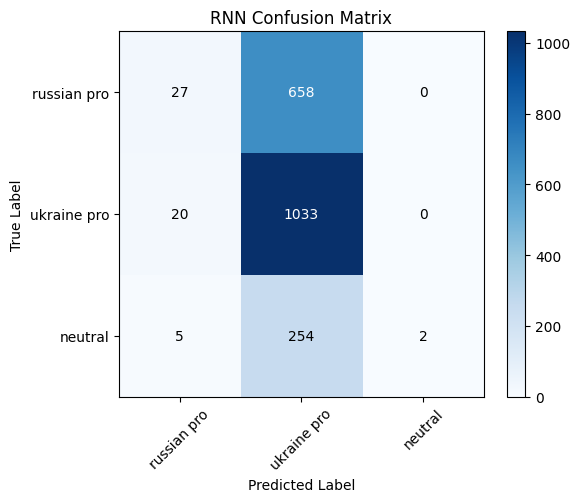

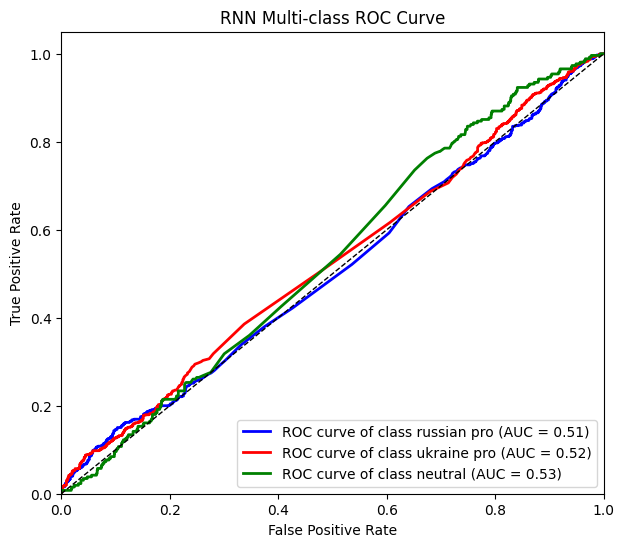

Average AUC Score: 0.5210518943340506


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

# --- Tokenize with BERT tokenizer for consistency ---
from transformers import BertTokenizer
tokenizer_rnn = BertTokenizer.from_pretrained('bert-base-uncased')

# --- Custom Dataset ---
class RNNDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=self.max_len)
        return torch.tensor(encoding, dtype=torch.long), torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    inputs, labels = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    return {'input_ids': inputs_padded, 'labels': torch.stack(labels)}

train_dataset_rnn = RNNDataset(train_texts, train_labels, tokenizer_rnn)
test_dataset_rnn = RNNDataset(test_texts, test_labels, tokenizer_rnn)

train_loader_rnn = DataLoader(train_dataset_rnn, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader_rnn = DataLoader(test_dataset_rnn, batch_size=16, collate_fn=collate_fn)

# --- Define RNN Model ---
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers=1):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        output, hidden = self.rnn(embedded)
        hidden = self.dropout(hidden[-1])
        return self.fc(hidden)

vocab_size = tokenizer_rnn.vocab_size
model_rnn = RNNClassifier(vocab_size=vocab_size, embed_dim=128, hidden_dim=128, output_dim=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_rnn.to(device)

# --- Training Setup ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=2e-4)

# --- Training Loop ---
epochs = 60
for epoch in range(epochs):
    model_rnn.train()
    total_loss = 0
    for batch in train_loader_rnn:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model_rnn(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader_rnn):.4f}")

# ===== Evaluation =====
model_rnn.eval()
rnn_preds, rnn_true, rnn_probs = [], [], []

with torch.no_grad():
    for batch in test_loader_rnn:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        outputs = model_rnn(input_ids)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        rnn_preds.extend(preds.cpu().numpy())
        rnn_true.extend(labels.cpu().numpy())
        rnn_probs.extend(probs.cpu().numpy())

#Accuracy
accuracy = accuracy_score(rnn_true, rnn_preds)
print(f"\n=== RNN Accuracy: {accuracy:.4f} ===\n")

#Classification Report
class_names = ['russian pro', 'ukraine pro', 'neutral']
print("=== Classification Report ===")
print(classification_report(rnn_true, rnn_preds, target_names=class_names))

#Confusion Matrix
cm = confusion_matrix(rnn_true, rnn_preds)
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("RNN Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

#ROC Curve
y_true_bin = label_binarize(rnn_true, classes=[0, 1, 2])
rnn_probs = np.array(rnn_probs)
n_classes = y_true_bin.shape[1]

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], rnn_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RNN Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

print("Average AUC Score:", roc_auc_score(y_true_bin, rnn_probs, average='macro'))

##predict

In [ ]:
def predict_sentiment_rnn(text):
    model_rnn.eval()
    encoding = tokenizer_rnn.encode(text, add_special_tokens=True, truncation=True, max_length=128)
    input_tensor = torch.tensor(encoding, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model_rnn(input_tensor)
    pred = torch.argmax(outputs, dim=-1).cpu().item()
    for key, val in label_map.items():
        if val == pred:
            return key

#Example Predictions
print(predict_sentiment_rnn("Ukraine deserves support."))
print(predict_sentiment_rnn("Russia is justified in its actions."))
print(predict_sentiment_rnn("Peace should come soon."))

russian pro
russian pro
russian pro


##LSTM model

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/30, Loss: 0.9740
Epoch 2/30, Loss: 0.9637
Epoch 3/30, Loss: 0.9659
Epoch 4/30, Loss: 0.9627
Epoch 5/30, Loss: 0.9599
Epoch 6/30, Loss: 0.9567
Epoch 7/30, Loss: 0.9513
Epoch 8/30, Loss: 0.9478
Epoch 9/30, Loss: 0.9436
Epoch 10/30, Loss: 0.9397
Epoch 11/30, Loss: 0.9332
Epoch 12/30, Loss: 0.9343
Epoch 13/30, Loss: 0.9312
Epoch 14/30, Loss: 0.8931
Epoch 15/30, Loss: 0.7766
Epoch 16/30, Loss: 0.6972
Epoch 17/30, Loss: 0.6519
Epoch 18/30, Loss: 0.6004
Epoch 19/30, Loss: 0.5593
Epoch 20/30, Loss: 0.5173
Epoch 21/30, Loss: 0.4840
Epoch 22/30, Loss: 0.4427
Epoch 23/30, Loss: 0.4098
Epoch 24/30, Loss: 0.3681
Epoch 25/30, Loss: 0.3432
Epoch 26/30, Loss: 0.3082
Epoch 27/30, Loss: 0.2751
Epoch 28/30, Loss: 0.2439
Epoch 29/30, Loss: 0.2308
Epoch 30/30, Loss: 0.2007

=== LSTM Accuracy: 0.7794 ===

=== Classification Report ===
              precision    recall  f1-score   support

 russian pro       0.82      0.80      0.81       685
 ukraine pro       0.79      0.83      0.81      1053
    

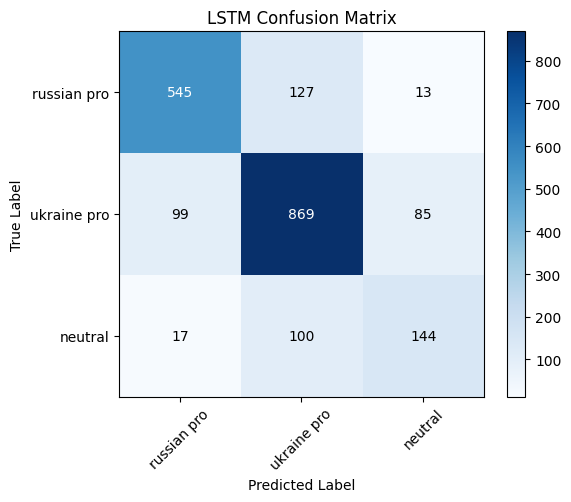

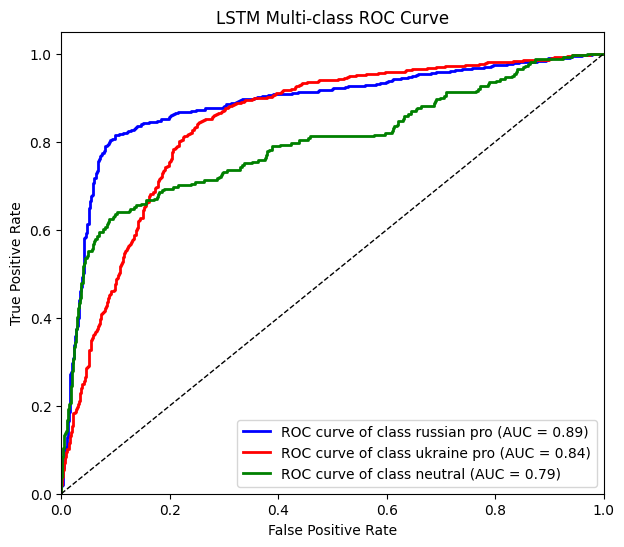

Average AUC Score: 0.8417577788898623


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

# --- Tokenizer ---
from transformers import BertTokenizer
tokenizer_lstm = BertTokenizer.from_pretrained('bert-base-uncased')

# --- Custom Dataset ---
class LSTMDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=self.max_len)
        return torch.tensor(encoding, dtype=torch.long), torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    inputs, labels = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    return {'input_ids': inputs_padded, 'labels': torch.stack(labels)}

train_dataset_lstm = LSTMDataset(train_texts, train_labels, tokenizer_lstm)
test_dataset_lstm = LSTMDataset(test_texts, test_labels, tokenizer_lstm)

train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=16, collate_fn=collate_fn)

# --- Define LSTM Model ---
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1])
        return self.fc(hidden)

vocab_size = tokenizer_lstm.vocab_size
model_lstm = LSTMClassifier(vocab_size=vocab_size, embed_dim=128, hidden_dim=128, output_dim=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_lstm.to(device)

# --- Training Setup ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=2e-4)

# --- Training Loop ---
epochs = 30
for epoch in range(epochs):
    model_lstm.train()
    total_loss = 0
    for batch in train_loader_lstm:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model_lstm(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader_lstm):.4f}")

# ===== Evaluation =====
model_lstm.eval()
lstm_preds, lstm_true, lstm_probs = [], [], []

with torch.no_grad():
    for batch in test_loader_lstm:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        outputs = model_lstm(input_ids)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        lstm_preds.extend(preds.cpu().numpy())
        lstm_true.extend(labels.cpu().numpy())
        lstm_probs.extend(probs.cpu().numpy())

#Accuracy ---
accuracy = accuracy_score(lstm_true, lstm_preds)
print(f"\n=== LSTM Accuracy: {accuracy:.4f} ===\n")

#Classification Report ---
class_names = ['russian pro', 'ukraine pro', 'neutral']
print("=== Classification Report ===")
print(classification_report(lstm_true, lstm_preds, target_names=class_names))

#Confusion Matrix ---
cm = confusion_matrix(lstm_true, lstm_preds)
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("LSTM Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

#ROC Curve ---
y_true_bin = label_binarize(lstm_true, classes=[0, 1, 2])
lstm_probs = np.array(lstm_probs)
n_classes = y_true_bin.shape[1]

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], lstm_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()

print("Average AUC Score:", roc_auc_score(y_true_bin, lstm_probs, average='macro'))

##predict

In [ ]:
def predict_sentiment_lstm(text):
    model_lstm.eval()
    encoding = tokenizer_lstm.encode(text, add_special_tokens=True, truncation=True, max_length=128)
    input_tensor = torch.tensor(encoding, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model_lstm(input_tensor)
    pred = torch.argmax(outputs, dim=-1).cpu().item()
    for key, val in label_map.items():
        if val == pred:
            return key

#Example Predictions
print(predict_sentiment_lstm("Ukraine deserves support."))
print(predict_sentiment_lstm("Russia is justified in its actions."))
print(predict_sentiment_lstm("We all want peace."))

ukraine pro
russian pro
neutral
